In [1]:
from IPython.core.interactiveshell import InteractiveShell
from datetime import datetime

#basic externals
import pandas as pd
import numpy as np
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype
import swifter
import feather
from random import randint
from scipy import stats
import io

#visual libs
import matplotlib.pyplot  as plt
import seaborn as sns
import cv2


#local imports
from xm_functions import *

InteractiveShell.ast_node_interactivity = "all"

pd.options.display.max_rows = 20
pd.options.display.max_columns = 50 
pd.set_option(
    "display.float_format", lambda x: "%.3f" % x
    )  # display numbers as decimals instead of scientific value

plt.rcParams["font.size"] = (18)

In [2]:
df = pd.read_feather('df_raw1.feather')

C:\Users\Maly-Fenix\Anaconda3\lib\site-packages\pyarrow\pandas_compat.py:752: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


In [3]:
df.dtypes

id             object
image          object
annotation     object
breed           int64
breed_label    object
pose           object
width           int64
height          int64
box_xmin        int64
box_ymin        int64
box_xmax        int64
box_ymax        int64
dtype: object

In [4]:
#fluffy pembroke sample

# Creating crop folders

In [5]:
import os

folders =  ['Cropped', 'Scene', 'Masked', 'Keras']
for folder in folders:
    try:os.mkdir(folder)
    except:pass
    
    for breed in df['breed_label'].unique():
        try:os.mkdir(folder+'/'+breed)
        except:pass

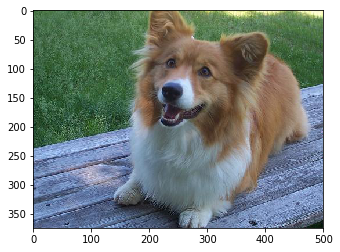

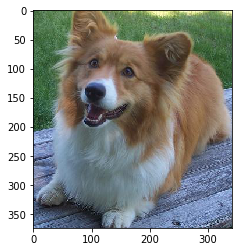

11136    Cropped/Pembroke/n02113023_12248.jpg
dtype: object

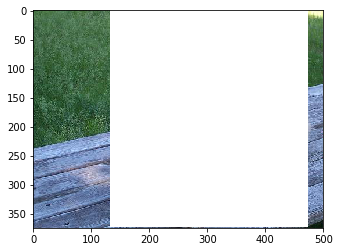

11136    Scene/Pembroke/n02113023_12248.png
dtype: object

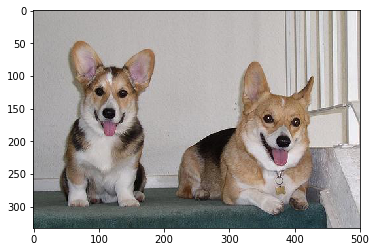

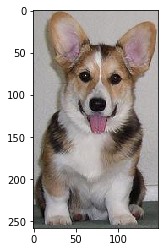

20068    Cropped/Pembroke/n02113023_2992.jpg
dtype: object

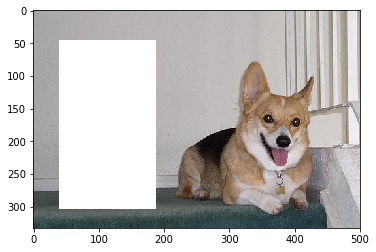

20068    Scene/Pembroke/n02113023_2992.png
dtype: object

In [6]:
def cropped_img(x, display_original = False, display_crop=False):
    img = cv2.imread(x['image'])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if display_original:
        plt.imshow(img)
        plt.show()
    
    crop_img = img[x['box_ymin']:x['box_ymax'], x['box_xmin']:x['box_xmax']]
    if display_crop:
        plt.imshow(crop_img)
        plt.show()
        
    crop_path='Cropped/'+x['breed_label']+'/'+x['id']+'.jpg'
    crop_img = cv2.cvtColor(crop_img, cv2.COLOR_BGR2RGB)
    img_created =cv2.imwrite(crop_path,crop_img)
    
    if img_created == False:
        print('Image not created ! ->', crop_path)

    return crop_path

def scene_img(x, display_original = False, display_crop=False):
    img = cv2.imread(x['image'])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGBA)
    if display_original:
        plt.imshow(img)
        plt.show()
    
    scene_img = img.copy()
    scene_img[x['box_ymin']:x['box_ymax'], x['box_xmin']:x['box_xmax']] = [0,0,0,0]
    if display_crop:
        plt.imshow(scene_img)
        plt.show()
        
    scene_path='Scene/'+x['breed_label']+'/'+x['id']+'.png'
    scene_img = cv2.cvtColor(scene_img, cv2.COLOR_BGR2RGBA)
    scene_created=cv2.imwrite(scene_path,scene_img)
    
    if scene_created == False:
        print('Image not created ! ->', scene_path)

    return scene_path
#Testing :
df_sample=df[df.id=='n02113023_12248']
df_sample.apply(lambda x: cropped_img(x, display_original =True, display_crop=True),axis=1)
df_sample.apply(lambda x: scene_img(x, display_original =False, display_crop=True),axis=1)
df_sample=df[df.id=='n02113023_2992']
df_sample.apply(lambda x: cropped_img(x, display_original =True, display_crop=True),axis=1)
df_sample.apply(lambda x: scene_img(x, display_original =False, display_crop=True),axis=1)


### Applying crop to all our pictures

In [23]:
if True == False:
    df['crop_img']=df.swifter.apply(lambda x: cropped_img(x),axis=1)
if True == False:
    df['scene_img']=df.swifter.apply(lambda x: scene_img(x),axis=1)

Pandas Apply: 100%|█████████████████████████████████████████████████████████████| 20580/20580 [03:18<00:00, 103.63it/s]


In [30]:
#df['crop_img'] =df['scene_img'].apply(lambda x: x.replace('Scene', 'Cropped').replace('png', 'jpg'))

In [31]:
df.sample(2)

,id,image,annotation,breed,breed_label,pose,width,height,box_xmin,box_ymin,box_xmax,box_ymax,scene_img,crop_img
16816,n02110063_7911,Images/n02110063-malamute/n02110063_7911.jpg,Annotation/n02110063-malamute/n02110063_7911,99,malamute,Unspecified,500,332,0,0,354,327,Scene/malamute/n02110063_7911.png,Cropped/malamute/n02110063_7911.jpg
17280,n02110806_3995,Images/n02110806-basenji/n02110806_3995.jpg,Annotation/n02110806-basenji/n02110806_3995,102,basenji,Unspecified,500,375,227,114,429,302,Scene/basenji/n02110806_3995.png,Cropped/basenji/n02110806_3995.jpg


In [91]:
divider=10
img_1d=np.array([100,255])
np.uint8(np.clip(np.round(img_1d/divider)*divider, 0,255) )
np.uint8(np.round(img_1d/divider)*divider)

array([100, 255], dtype=uint8)

array([100,   4], dtype=uint8)

### Manual masking of background based on surronding scene

### Reducing colors

In [ ]:

def plot_colors2(hist, centroids):
    bar = np.zeros((50, 300, 3), dtype="uint8")
    startX = 0

    for (percent, color) in zip(hist, centroids):
        # plot the relative percentage of each cluster
        endX = startX + (percent * 300)
        cv2.rectangle(bar, (int(startX), 0), (int(endX), 50),
                      color.astype("uint8").tolist(), -1)
        startX = endX

    # return the bar chart
    return bar



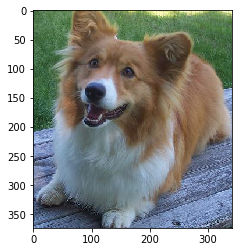

    colorR  colorG  colorB      0  color_percent
18      85     127      85  11770          9.202
25     127     127      85  10565          8.260
22     127      85      85   9353          7.312
27     127     127     170   8613          6.734
26     127     127     127   8521          6.662
19      85     127     127   8362          6.538
14      85      85      85   7506          5.868
15      85      85     127   5961          4.660
13      85      85      42   5758          4.502
35     170     127     127   5667          4.431


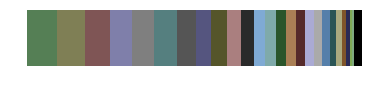

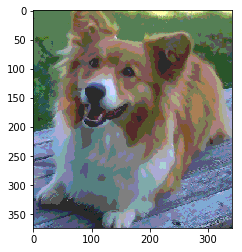

    colorR  colorG  colorB      0  color_percent
8       42      85      42  12749         21.171
18      85     127      85  12737         21.151
24     127     127     170   5986          9.941
29     127     170     212   5812          9.652
9       42      85      85   4838          8.034
15      85      85     127   4817          7.999
20      85     127     170   4395          7.298
14      85      85      85   2184          3.627
34     170     170     212   1884          3.129
0        0       0       0    642          1.066


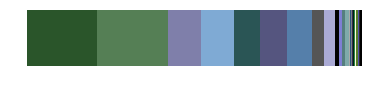

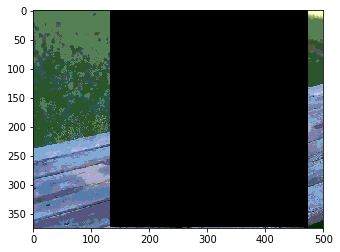

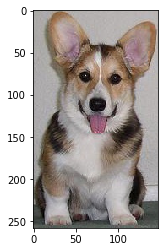

    colorR  colorG  colorB      0  color_percent
29     170     170     170  14758         38.650
26     170     127     127   3625          9.494
20     127     127     127   3493          9.148
12      85      85      85   2762          7.233
5       42      42      42   2031          5.319
17     127      85      85   2013          5.272
19     127     127      85   1836          4.808
28     170     170     127   1223          3.203
36     212     212     212   1011          2.648
11      85      85      42    870          2.278


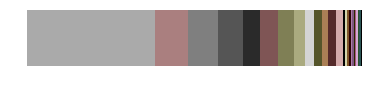

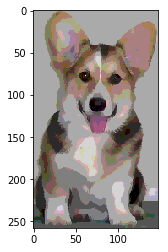

    colorR  colorG  colorB      0  color_percent
31     170     170     170  53090         41.349
38     212     212     212  14821         11.543
13      85      85      85   9042          7.042
35     212     170     170   8847          6.890
8       42      85      85   6541          5.094
28     170     127     127   4998          3.893
30     170     170     127   3881          3.023
27     170     127      85   3598          2.802
37     212     212     170   3434          2.675
18     127      85      85   3328          2.592


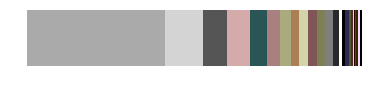

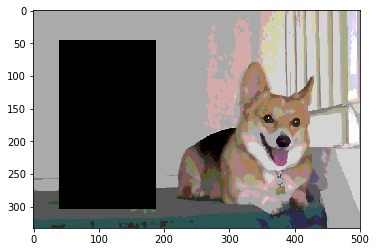

In [298]:
import collections

def reduce_colors(img, divider = 42.5, display = False):
    color_dimensions = img.shape[2]
    img = cv2.bilateralFilter(img,6,80,50)
    img_1d =img.reshape((img.shape[0] * img.shape[1],color_dimensions))
    
    colorcols=[ 'colorR', 'colorG','colorB']
    df = pd.DataFrame(img_1d, columns=colorcols)
    mask = (((df['colorR'] ==  0) & (df['colorG'] == 0) & (df['colorB']==0)))
    
    #reduce number of different colors 
    # clip before uint8 is important !
    img_1d = np.uint8(np.clip(np.round(img_1d/divider)*divider, 0,255) )
    df = pd.DataFrame(img_1d, columns=colorcols)
    df=df[~mask]  
        
    color_hist = df.groupby(colorcols).agg('size').reset_index().sort_values(0,ascending = False).head(25)
    color_hist['color_percent']= color_hist[0]*100/df.shape[0]
    
    if display:
        print(color_hist.head(10))
        bar = plot_colors2(color_hist['color_percent'].values/100, color_hist.loc[:,colorcols].values)
        plt.axis("off")
        plt.imshow(bar)
        plt.show()
        
    img_2d = img_1d.reshape((img.shape[0], img.shape[1],color_dimensions))
    return img_2d, color_hist
    
def img_less_colors(x, divider = 42.5, display = False):
    img = cv2.imread(x['crop_img'])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if display:
        plt.imshow(img)
        plt.show()
    img_less, color_hist = reduce_colors(img, divider, display)
    if display:
        plt.imshow(img_less)
        plt.show()
        
    scene = cv2.imread(x['scene_img'], cv2.IMREAD_UNCHANGED) #IMREAD_UNCHANGED to keep 4th channel with transparency
    scene = cv2.cvtColor(scene, cv2.COLOR_BGR2RGB) 
    scene_less, color_hist_scene = reduce_colors(scene, divider, display)
    if display:
        plt.imshow(scene_less)
        plt.show()
    return img_less, color_hist_scene

df_sample=df[df.id=='n02113023_12248']
silent = df_sample.apply(lambda x: img_less_colors(x, display =True),axis=1)
df_sample=df[df.id=='n02113023_2992']
silent = df_sample.apply(lambda x: img_less_colors(x, display =True),axis=1)

### Apply mask based on reduced color of the scene 

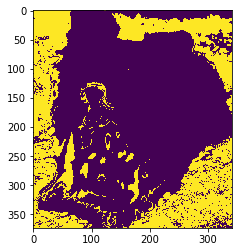

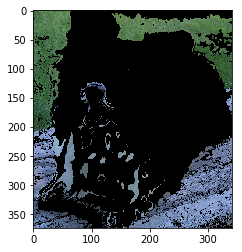

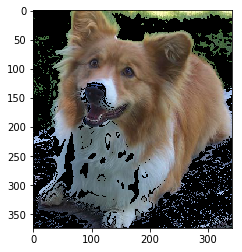

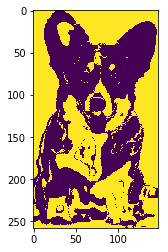

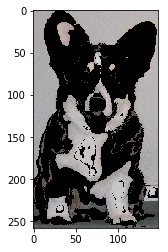

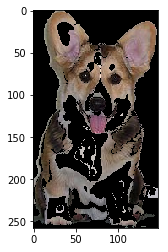

In [317]:
def remove_scene_colors(x, display =False):
    img_less, color_hist_scene = img_less_colors(x)
    
    color_delete = color_hist_scene[color_hist_scene.color_percent > 4].values
    for i in range(color_delete.shape[0]):
        color = color_delete[i]
        color = np.uint8(np.array(color[:3]))
        if i ==0:
            mask= cv2.inRange(img_less, color, color)
        else:
            mask+=cv2.inRange(img_less, color, color)
        
    
    img = cv2.imread(x['crop_img'])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    masked_img = cv2.bitwise_and(img, img, mask=~mask)
    if display:
        plt.imshow(mask)
        plt.show()
        plt.imshow(cv2.bitwise_and(img, img, mask=mask) )
        plt.show()
        plt.imshow(masked_img )
        plt.show()
    
    #Created masked image
    masked_path='Masked/'+x['breed_label']+'/'+x['id']+'.png'
    masked_img = cv2.cvtColor(masked_img, cv2.COLOR_BGR2RGBA)
    masked_created=cv2.imwrite(masked_path,masked_img)
    
    return masked_path

df_sample=df[df.id=='n02113023_12248']
df.loc[df_sample.index, 'masked_img'] = df_sample.apply(lambda x: remove_scene_colors(x, display =True),axis=1)
df_sample=df[df.id=='n02113023_2992']
df.loc[df_sample.index, 'masked_img'] = df_sample.apply(lambda x: remove_scene_colors(x, display =True),axis=1)

In [323]:
if True == True:
    df['masked_img']=df.swifter.apply(lambda x: remove_scene_colors(x),axis=1)

Pandas Apply: 100%|██████████████████████████████████████████████████████████████| 20580/20580 [46:47<00:00,  7.33it/s]


#### Get average dominant colors by kmeans

[0.15143763 0.07599168 0.09307957 0.0948418  0.11075867 0.16471685
 0.00936821 0.05503826 0.07786759 0.16689974]


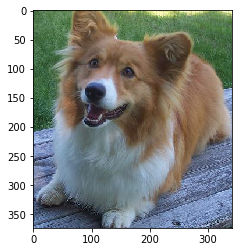

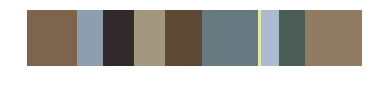

19159    None
dtype: object

[0.09065744 0.10992813 0.11562417 0.12893266 0.13617248 0.08331115
 0.1546979  0.02155976 0.07202555 0.08709076]


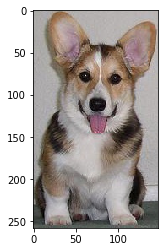

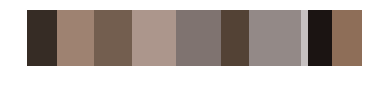

19219    None
dtype: object

In [321]:
from sklearn.cluster import KMeans
def find_histogram(clt):
    """
    create a histogram with k clusters
    :param: clt
    :return:hist
    """
    numLabels = np.arange(0, len(np.unique(clt.labels_)) + 1)
    (hist, _) = np.histogram(clt.labels_, bins=numLabels)

    hist = hist.astype("float")
    hist /= hist.sum()

    return hist

def color_bar(x, display = False):
    img_2d = cv2.imread(x['crop_img'])
    img_2d = cv2.cvtColor(img_2d, cv2.COLOR_BGR2RGB)
    
    img = cv2.imread(x['masked_img'])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    img_1d = img.reshape((img.shape[0] * img.shape[1],3)) #represent as row*column,channel number
    
    colorcols=[ 'colorR', 'colorG','colorB']
    df = pd.DataFrame(img_1d, columns=colorcols)
    mask = (((df['colorR'] ==  0) & (df['colorG'] == 0) & (df['colorB']==0)))
    df = pd.DataFrame(img_1d, columns=colorcols)
    df=df[~mask]
    img_1d = df.values
        
    clt = KMeans(n_clusters=10) #cluster number
    clt.fit(img_1d)

    hist = find_histogram(clt)
    if display:
        plt.imshow(img_2d)
        plt.show()
        bar = plot_colors2(hist, clt.cluster_centers_)

        plt.axis("off")
        plt.imshow(bar)
        plt.show()
        
    return 


df_sample=df[df.id=='n02113023_12248']
df_sample.apply(lambda x: color_bar(x, display =True),axis=1)
df_sample=df[df.id=='n02113023_2992']
df_sample.apply(lambda x: color_bar(x, display =True),axis=1)

## Results

Not too bad but too slow. And the mask has removed significant parts of the image. like the white collar of these dogs

Export

In [324]:
df.to_feather('df_transformed1.feather')